In [33]:
# pytorch mlp for regression
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import math
import os
from sklearn.datasets import make_regression
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import seaborn as sns

custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_theme(style="whitegrid", font_scale=1.2, palette=custom_colors)

In [34]:
path = 'data/active/active1999-2001.cleaned.csv'
df = pd.read_csv(path)
df

,site,age,edu,group,booster,sex,reason,ufov,hvltt,hvltt2,hvltt3,hvltt4,mmse,id
0,1,76,12,1,1,0,28,16,28,28,17,22,27,1
1,1,67,10,1,1,1,13,20,24,22,20,27,25,2
2,6,67,13,3,1,1,24,16,24,24,28,27,27,3
3,5,72,16,1,1,1,33,16,35,34,32,34,30,4
4,4,69,12,4,0,1,30,16,35,29,34,34,28,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,4,66,12,3,0,1,51,16,35,32,35,35,29,1571
1569,3,77,12,3,0,1,38,30,30,21,22,26,26,1572
1570,2,76,13,1,0,1,42,16,36,32,34,35,29,1573
1571,5,69,17,4,0,0,40,16,29,29,28,28,28,1574


In [35]:
# Define the input and output columns
input_vars = ['age', 'edu', 'sex'] # 3 predictors
# input_vars = ['age', 'edu', 'sex', 'hvltt', 'hvltt2', 'hvltt3', 'reason', 'booster', 'ufov', 'mmse'] # 10 predictors
output_vars = ['hvltt4']

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

# Split the data into inputs and outputs
train_inputs, train_outputs = train_df[input_vars], train_df[output_vars]
val_inputs, val_outputs = val_df[input_vars], val_df[output_vars]
test_inputs, test_outputs = test_df[input_vars], test_df[output_vars]

len(train_inputs), len(val_inputs), len(test_inputs)

(1136, 201, 236)

In [36]:
train_inputs

,age,edu,sex
1530,65,12,1
902,70,13,0
909,83,12,1
1365,72,16,0
1308,66,13,1
...,...,...,...
472,84,12,1
1153,70,16,0
686,68,12,1
848,79,14,1


In [55]:
train_outputs

,hvltt4
1530,34
902,27
909,27
1365,26
1308,27
...,...
472,21
1153,29
686,33
848,23


In [37]:
# Normalize predictors
scaler = StandardScaler()
train_inputs_normalized = pd.DataFrame(scaler.fit_transform(train_inputs), columns=train_inputs.columns)
val_inputs_normalized = pd.DataFrame(scaler.transform(val_inputs), columns=val_inputs.columns)
test_inputs_normalized = pd.DataFrame(scaler.transform(test_inputs), columns=test_inputs.columns)

train_inputs_normalized

,age,edu,sex
0,-1.447581,-0.656491,0.542079
1,-0.547990,-0.273060,-1.844750
2,1.790946,-0.656491,0.542079
3,-0.188154,0.877234,-1.844750
4,-1.267663,-0.273060,0.542079
...,...,...,...
1131,1.970864,-0.656491,0.542079
1132,-0.547990,0.877234,-1.844750
1133,-0.907827,-0.656491,0.542079
1134,1.071273,0.110371,0.542079


In [39]:
# Convert the inputs and outputs to PyTorch tensors
train_inputs_tensor = torch.tensor(train_inputs_normalized.values, dtype=torch.float32)
train_outputs_tensor = torch.tensor(train_outputs.values, dtype=torch.float32)
val_inputs_tensor = torch.tensor(val_inputs_normalized.values, dtype=torch.float32)
val_outputs_tensor = torch.tensor(val_outputs.values, dtype=torch.float32)
test_inputs_tensor = torch.tensor(test_inputs_normalized.values, dtype=torch.float32)
test_outputs_tensor = torch.tensor(test_outputs.values, dtype=torch.float32)

# Create TensorDatasets for train and validation sets
train_dataset = TensorDataset(train_inputs_tensor, train_outputs_tensor)
val_dataset = TensorDataset(val_inputs_tensor, val_outputs_tensor)
test_dataset = TensorDataset(test_inputs_tensor, test_outputs_tensor)

In [40]:
# Create FNN model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): ReLU()
  )
)


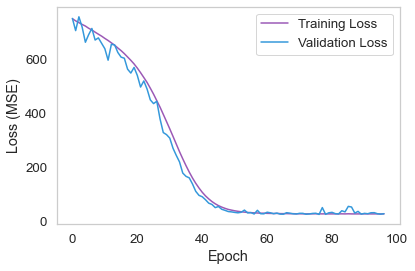

Best validation loss: 25.563886404037476


In [63]:
# Set random seed for reproducibility
np.random.seed(64)

# Define the input size, hidden sizes, and output size
input_size = len(input_vars)
hidden_sizes = [4]  # Hidden layer sizes
output_size = len(output_vars)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_sizes, output_size)
print(model)

# Create DataLoaders for train and validation sets
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Train the model
num_epochs = 1000
learning_rate = 0.0001
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
epochs_no_improve = 0
patience=20
min_delta=0.0001
    
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # Set the model to training mode
    model.train()

    # Forward pass
    train_loss = 0
    for inputs, outputs in train_dataloader:
        optimizer.zero_grad()
        train_outputs_pred = model(inputs)
        loss = criterion(train_outputs_pred, outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Set the model to evaluation mode
    model.eval()

    # Forward pass for validation set
    val_loss = 0
    with torch.no_grad():
        for inputs, outputs in val_dataloader:
            val_outputs_pred = model(inputs)
            loss = criterion(val_outputs_pred, outputs)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
    

    # Append the training and validation losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Check for early stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            # print("Early stopping triggered")
            break

# Plot the convergence curve
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.savefig('results_simple/convergence_curve.pdf')
plt.show()

print(f"Best validation loss: {best_val_loss}")

Test loss: 27.19770050048828


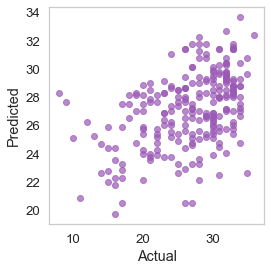

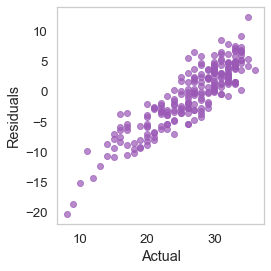

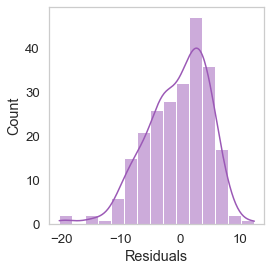

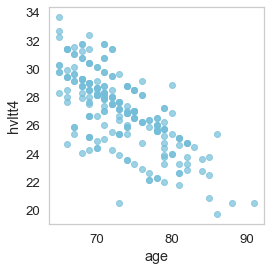

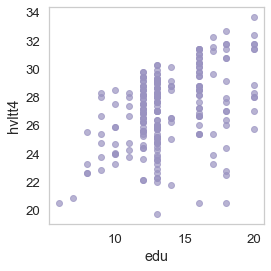

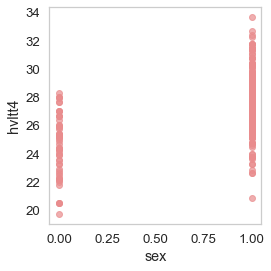

In [76]:
# Test the model
model.eval()
test_outputs_pred = model(test_inputs_tensor)
test_loss = criterion(test_outputs_pred, test_outputs_tensor).item()
test_outputs_pred = test_outputs_pred.detach().numpy().flatten().tolist()
print(f"Test loss: {test_loss}")

# print(test_outputs)
# print(test_outputs_pred)

# Plot the predicted vs actual values
plt.figure(figsize=(4, 4))
plt.scatter(test_outputs, test_outputs_pred, alpha=0.7)
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.title('Predicted vs Actual')
plt.grid(False)
plt.tight_layout()
plt.savefig('results_simple/plots/interpretation/predicted_vs_actual.pdf')
plt.show()

# Plot the residuals
residuals = [x - y for x, y in zip(test_outputs[output_vars[0]].to_list(), test_outputs_pred)]
plt.figure(figsize=(4, 4))
plt.scatter(test_outputs, residuals, alpha=0.7)
plt.xlabel('Actual')
plt.ylabel('Residuals')
# plt.title('Residuals vs Actual')
plt.grid(False)
plt.tight_layout()
# plt.savefig('results_simple/plots/interpretation/residuals_vs_actual.pdf')
plt.show()

# Plot the distribution of residuals
plt.figure(figsize=(4, 4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
# plt.title('Distribution of Residuals')
plt.grid(False)
plt.tight_layout()
# plt.savefig('results_simple/plots/interpretation/residuals_distribution.pdf')
plt.show()

custom_colors = ['#74bed9', '#9a93c1', '#e98c8d']
# PLot the predicted vs predictors
for i in range(len(input_vars)):
    plt.figure(figsize=(4, 4))
    plt.scatter(test_inputs[input_vars[i]], test_outputs_pred, alpha=0.7, color=custom_colors[i])
    plt.xlabel(input_vars[i])
    plt.ylabel(output_vars[0])
    # plt.title(f'Predicted {output_vars[0]} vs {input_vars[i]}')
    plt.grid(False)
    plt.tight_layout()
    # plt.savefig(f'results_simple/plots/interpretation/predicted_vs_{input_vars[i]}.pdf')
    plt.show()



In [31]:
# Define the possible values for hyperparameters
hidden_layers = [1, 2, 3]
neurons_per_layer = [4, 8, 32, 64, 128]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes = [8, 16, 32, 64, 128]

num_epochs = 2000

train_losses = []
val_losses = []

def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, lr, patience=20, min_delta=0.0001):
    # Set the learning rate and batch size
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    train_losses = []
    val_losses = []
    
    # for epoch in range(num_epochs):
    while True:
        
        model.train()
        train_loss = 0
        for inputs, outputs in train_dataloader:
            optimizer.zero_grad()
            train_outputs = model(inputs)
            loss = criterion(train_outputs, outputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, outputs in val_dataloader:
                val_outputs = model(inputs)
                loss = criterion(val_outputs, outputs)
                val_loss += loss.item()
            val_loss /= len(val_dataloader)
            
        # Append the training and validation losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)


        # Check for early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                # print("Early stopping triggered")
                break

    return train_losses, val_losses

n_replications = 100

# Iterate over all hyperparameter combinations
for num_layers in hidden_layers:
    for num_neurons in neurons_per_layer:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                
                if os.path.isfile(f"results_simple/replications/performance/{num_layers}_{num_neurons}_{lr}_{batch_size}.csv"):
                    print(f"results_simple/replications/performance/{num_layers}_{num_neurons}_{lr}_{batch_size}.csv already exists")
                    continue
                
                print(f"num_layers: {num_layers}, num_neurons: {num_neurons}, lr: {lr}, batch_size: {batch_size}")
                
                # Create a dataframe to store the performance of the model
                df_performance = pd.DataFrame(columns=['num_layers', 'num_neurons', 'lr', 'batch_size', 'rep_id', 'MSE', 'n_epochs'])
                # And a dataframe to store the input, actual and predicted values
                df_val = pd.DataFrame(val_inputs, columns=input_vars)
                df_val['hvltt4_actual'] = val_outputs
                
                for rep_id in tqdm(range(n_replications)):
                   
                    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

                    model = NeuralNetwork(input_size, [num_neurons]*num_layers, output_size)
                    criterion = nn.MSELoss()
                    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

                    # Train the model
                    train_losses, val_losses = train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, lr)
                    
                    # df_convergence = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
                    # df_convergence.to_csv(f"results_simple/replications/convergence/{num_layers}_{num_neurons}_{lr}_{batch_size}.{rep_id}.csv", index = False)
                    
                    model.eval()
                    with torch.no_grad():
                        val_outputs_pred = model(val_inputs_tensor)
                    df_val[f'hvltt4_pred.{rep_id}'] = val_outputs_pred.numpy()               
                    
                    # print(f"num_layers: {num_layers}, num_neurons: {num_neurons}, lr: {lr}, batch_size: {batch_size}, val_loss: {val_losses[-1]}, epochs: {len(val_losses)}")
                    
                    # Plot the convergence curve
                    # plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
                    # plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
                    # plt.xlabel('Epoch')
                    # plt.ylabel('Loss (MSE)')
                    # plt.legend()
                    # plt.savefig(f"results_simple/convergence/{num_layers}_{num_neurons}_{lr}_{batch_size}_loss={round(val_losses[-1], 4)}_epochs={len(val_losses)}.pdf", format='pdf')
                    # # plt.show()
                    # plt.clf()

                    df_performance = df_performance.append({'num_layers': num_layers, 'num_neurons': num_neurons, 'lr': lr, 'batch_size': batch_size, 'rep_id': rep_id, 'MSE': val_losses[-1], 'n_epochs': len(val_losses)}, ignore_index=True)

                print(df_val)
                df_val.to_csv(f"results_simple/replications/predictions/{num_layers}_{num_neurons}_{lr}_{batch_size}.csv", index = False)
                
                print(df_performance)
                df_performance.to_csv(f"results_simple/replications/performance/{num_layers}_{num_neurons}_{lr}_{batch_size}.csv", index = False)